In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from random import choice
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import seaborn as sns
from math import sqrt
from datetime import datetime

sns.set_style("whitegrid")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

In [70]:
dtype = {
    'BEGIN_YEARMONTH': int,
    'BEGIN_DAY': int,
    'BEGIN_TIME': 'Int64',
    'END_YEARMONTH': int,
    'END_DAY': int,
    'END_TIME': int,
    'EPISODE_ID': 'Int64',
    'EVENT_ID': 'Int64',
    'STATE': str,
    'STATE_FIPS': 'Int64',
    'YEAR': 'Int64',
    'MONTH_NAME': str,
    'EVENT_TYPE': str,
    'CZ_TYPE': str,
    'CZ_FIPS': 'Int64',
    'CZ_NAME': str,
    'WFO': str,
    'BEGIN_DATE_TIME': str,
    'CZ_TIMEZONE': str,
    'END_DATE_TIME': str,
    'INJURIES_DIRECT': 'Int64',
    'INJURIES_INDIRECT': 'Int64',
    'DEATHS_DIRECT': 'Int64',
    'DEATHS_INDIRECT': 'Int64',
    'DAMAGE_PROPERTY': str,
    'DAMAGE_CROPS': str,
    'SOURCE': str,
    'MAGNITUDE': 'Float64',
    'MAGNITUDE_TYPE': str,
    'FLOOD_CAUSE': str,
    'TOR_F_SCALE': str,
    'TOR_LENGTH': 'Float64',
    'TOR_WIDTH': 'Float64',
    'TOR_OTHER_WFO': str,
    'TOR_OTHER_CZ_STATE': str,
    'TOR_OTHER_CZ_FIPS': 'Int64',
    'TOR_OTHER_CZ_NAME': str,
    'BEGIN_RANGE': 'Float64',
    'BEGIN_AZIMUTH': str,
    'BEGIN_LOCATION': str,
    'END_RANGE': 'Float64',
    'END_AZIMUTH': str,
    'END_LOCATION': str,
    'BEGIN_LAT': 'Float64',
    'BEGIN_LON': 'Float64',
    'END_LAT': 'Float64',
    'END_LON': 'Float64',
    'EPISODE_NARRATIVE': str,
    'EVENT_NARRATIVE': str,
    'DATA_SOURCE': str,
    'TOR_F_SCALE_MAPPED': 'str',
    'DAMAGE_CROPS_DESUFFIX': 'Float64',
    'DAMAGE_PROPERTY_DESUFFIX': 'Float64'
}

tdf = pd.read_csv('../StormEvents_details_WORKING.csv',dtype=dtype)
tdf['TOR_F_SCALE_MAPPED'] = tdf.TOR_F_SCALE_MAPPED.fillna('N/A')


In [106]:
'1234'[-2:]

'34'

In [108]:
tdf.rename({'Unnamed: 0':'STORM_ID'},axis=1,inplace=True)

tdf = tdf[(~tdf['BEGIN_LAT'].isna()) & (~tdf['BEGIN_LON'].isna())]

tdf['BEGIN_YEAR'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[0:4]))
tdf['BEGIN_DECADE'] = (tdf['BEGIN_YEAR'] // 10) * 10
tdf['BEGIN_MONTH'] = tdf['BEGIN_YEARMONTH'].apply(lambda ym : int(str(ym)[-2:]))
tdf['CASUALTIES'] = tdf[['DEATHS_DIRECT','DEATHS_INDIRECT','INJURIES_DIRECT','INJURIES_INDIRECT']].sum(axis=1)
tdf['BEGIN_QUARTER'] = tdf['BEGIN_MONTH'] // 4
tdf['BEGIN_YEAR_QUARTER'] = tdf['BEGIN_YEAR'] * 10 + tdf['BEGIN_QUARTER']
tdf['FIPS'] = tdf['STATE_FIPS'] * 1000 + tdf['CZ_FIPS']
tdf['BEGIN_DATE_STR'] = tdf.apply(lambda r : str(r.BEGIN_YEARMONTH) + str(r.BEGIN_DAY),axis=1)
tdf['BEGIN_DATE'] = pd.to_datetime(tdf['BEGIN_DATE_STR'],format='%Y%m%d')
tdf['BEGIN_DAY_OF_YEAR'] = tdf['BEGIN_DATE'].dt.day_of_year         # yeah, i gotcha
tdf['BEGIN_WEEK_OF_YEAR'] = tdf['BEGIN_DATE'].dt.isocalendar().week # ohhhhh
tdf['BEGIN_WEEK_YEAR'] = tdf['BEGIN_YEAR'] + (tdf['BEGIN_WEEK_OF_YEAR']/52)
tdf['BEGIN_MONTH_YEAR'] = tdf['BEGIN_YEAR'] + (tdf['BEGIN_MONTH']/12)
tdf['BEGIN_YEAR_OF_DECADE'] = tdf.apply(lambda r : r.BEGIN_DECADE + int(str(r.BEGIN_YEAR)[-2:])/10 ,axis=1)

grouped = tdf.groupby('EPISODE_ID').count().reset_index()[['EPISODE_ID','STORM_ID']]
multi_episodes = grouped[grouped['STORM_ID'] > 1]['EPISODE_ID']
tdf['CLUSTER_EPISODE_ID'] = tdf['EPISODE_ID'].apply(lambda e : e if e in multi_episodes else np.nan)

historic_lat_mean = tdf['BEGIN_LAT'].mean()
historic_lon_mean = tdf['BEGIN_LON'].mean()

# Assign orientation of a tornado to the historical mean of all tornadoes
conditions = [
    (tdf['BEGIN_LAT'] > historic_lat_mean) & (tdf['BEGIN_LON'] < historic_lon_mean),  
    (tdf['BEGIN_LAT'] <= historic_lat_mean) & (tdf['BEGIN_LON'] < historic_lon_mean), 
    (tdf['BEGIN_LAT'] <= historic_lat_mean) & (tdf['BEGIN_LON'] >= historic_lon_mean),
    (tdf['BEGIN_LAT'] > historic_lat_mean) & (tdf['BEGIN_LON'] >= historic_lon_mean)  
]

orientations = [
    0,  # NE 
    1,  # SE
    2,  # SW 
    3   # NW
    ]

# Assign orientation based on conditions
tdf['ORIENTATION_FROM_MEAN'] = np.select(conditions, orientations)    

# pull in the population of a State-County FIPS at the time of the tornado 
county_pop = pd.read_csv('../assets/county_population.csv')[['fips','county','state','year','population']]
tdf_cpop = pd.merge(tdf,county_pop, how='left', left_on=['FIPS','BEGIN_YEAR'],right_on=['fips','year'])

# Omit tornadoes without Population figures
tdf_cpop = tdf_cpop[
    (
        ~tdf_cpop['fips'].isna()
    )]

dev_df = pd.read_csv('../assets/Tornado_Damage_By_County.csv')
tpd_df = pd.merge(tdf_cpop,dev_df,left_on='fips',right_on='STCOFIPS')

# Remove the 'POPULATION' field from the devestation index dataset
# since the 'population' column uses historical census data
tpd_df.drop(['POPULATION','fips'],axis=1,inplace=True)

for col in ['population','CASUALTIES','TOR_WIDTH','TOR_LENGTH','AGRIVALUE','BUILDVALUE']:
    tpd_df['LOG_'+col.upper()] = np.log10(tpd_df[col])

rel_cols = [
    'STORM_ID',
    'EPISODE_ID',
    'EVENT_ID',
    'BEGIN_DAY',
    'BEGIN_YEAR',
    'BEGIN_DECADE',
    'BEGIN_YEAR_OF_DECADE',
    'BEGIN_MONTH',
    'BEGIN_QUARTER',
    'BEGIN_YEAR_QUARTER',
    'BEGIN_DATE',
    'BEGIN_DAY_OF_YEAR',
    'BEGIN_WEEK_OF_YEAR',
    'BEGIN_WEEK_YEAR',
    'BEGIN_MONTH_YEAR',

    'ORIENTATION_FROM_MEAN',
    'COUNTY',
    'STATE',
    'FIPS',
    'POPULATION',
    'LOG_POPULATION',            

    'INJURIES_DIRECT',
    'INJURIES_INDIRECT',
    'DEATHS_DIRECT',
    'DEATHS_INDIRECT',

    'TOR_LENGTH',
    'LOG_TOR_LENGTH',
    'TOR_WIDTH',
    'LOG_TOR_WIDTH',
    'BEGIN_LAT',
    'BEGIN_LON',
    'EPISODE_NARRATIVE',
    'EVENT_NARRATIVE',
    'TOR_F_SCALE_MAPPED',

    'CASUALTIES',
    'LOG_CASUALTIES',
    'CLUSTER_EPISODE_ID',

    'BUILDVALUE',
    'LOG_BUILDVALUE',
    'LOG_AGRIVALUE',
    'AGRIVALUE',
    'RESL_SCORE',
    'SOVI_SCORE',
    'DEVASTATION_INDEX',
    'FATALITY_EF0',
    'INJURY_EF0',
    'DAMAGE_EF0',
    'FATALITY_EF1',
    'INJURY_EF1',
    'DAMAGE_EF1',
    'FATALITY_EF2',
    'INJURY_EF2',
    'DAMAGE_EF2',
    'FATALITY_EF3',
    'INJURY_EF3',
    'DAMAGE_EF3',
    'FATALITY_EF4',
    'INJURY_EF4',
    'DAMAGE_EF4',
    'FATALITY_EF5',
    'INJURY_EF5',
    'DAMAGE_EF5']

tpd_df.rename({col: col.upper() for col in tpd_df.columns},axis=1,inplace=True)
tpd_df = tpd_df[rel_cols]

tpd_df.to_csv('current.csv')

/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arrays/masked.py:672: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs2, **kwargs)
/opt/anaconda3/envs/ErdosMay2024/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


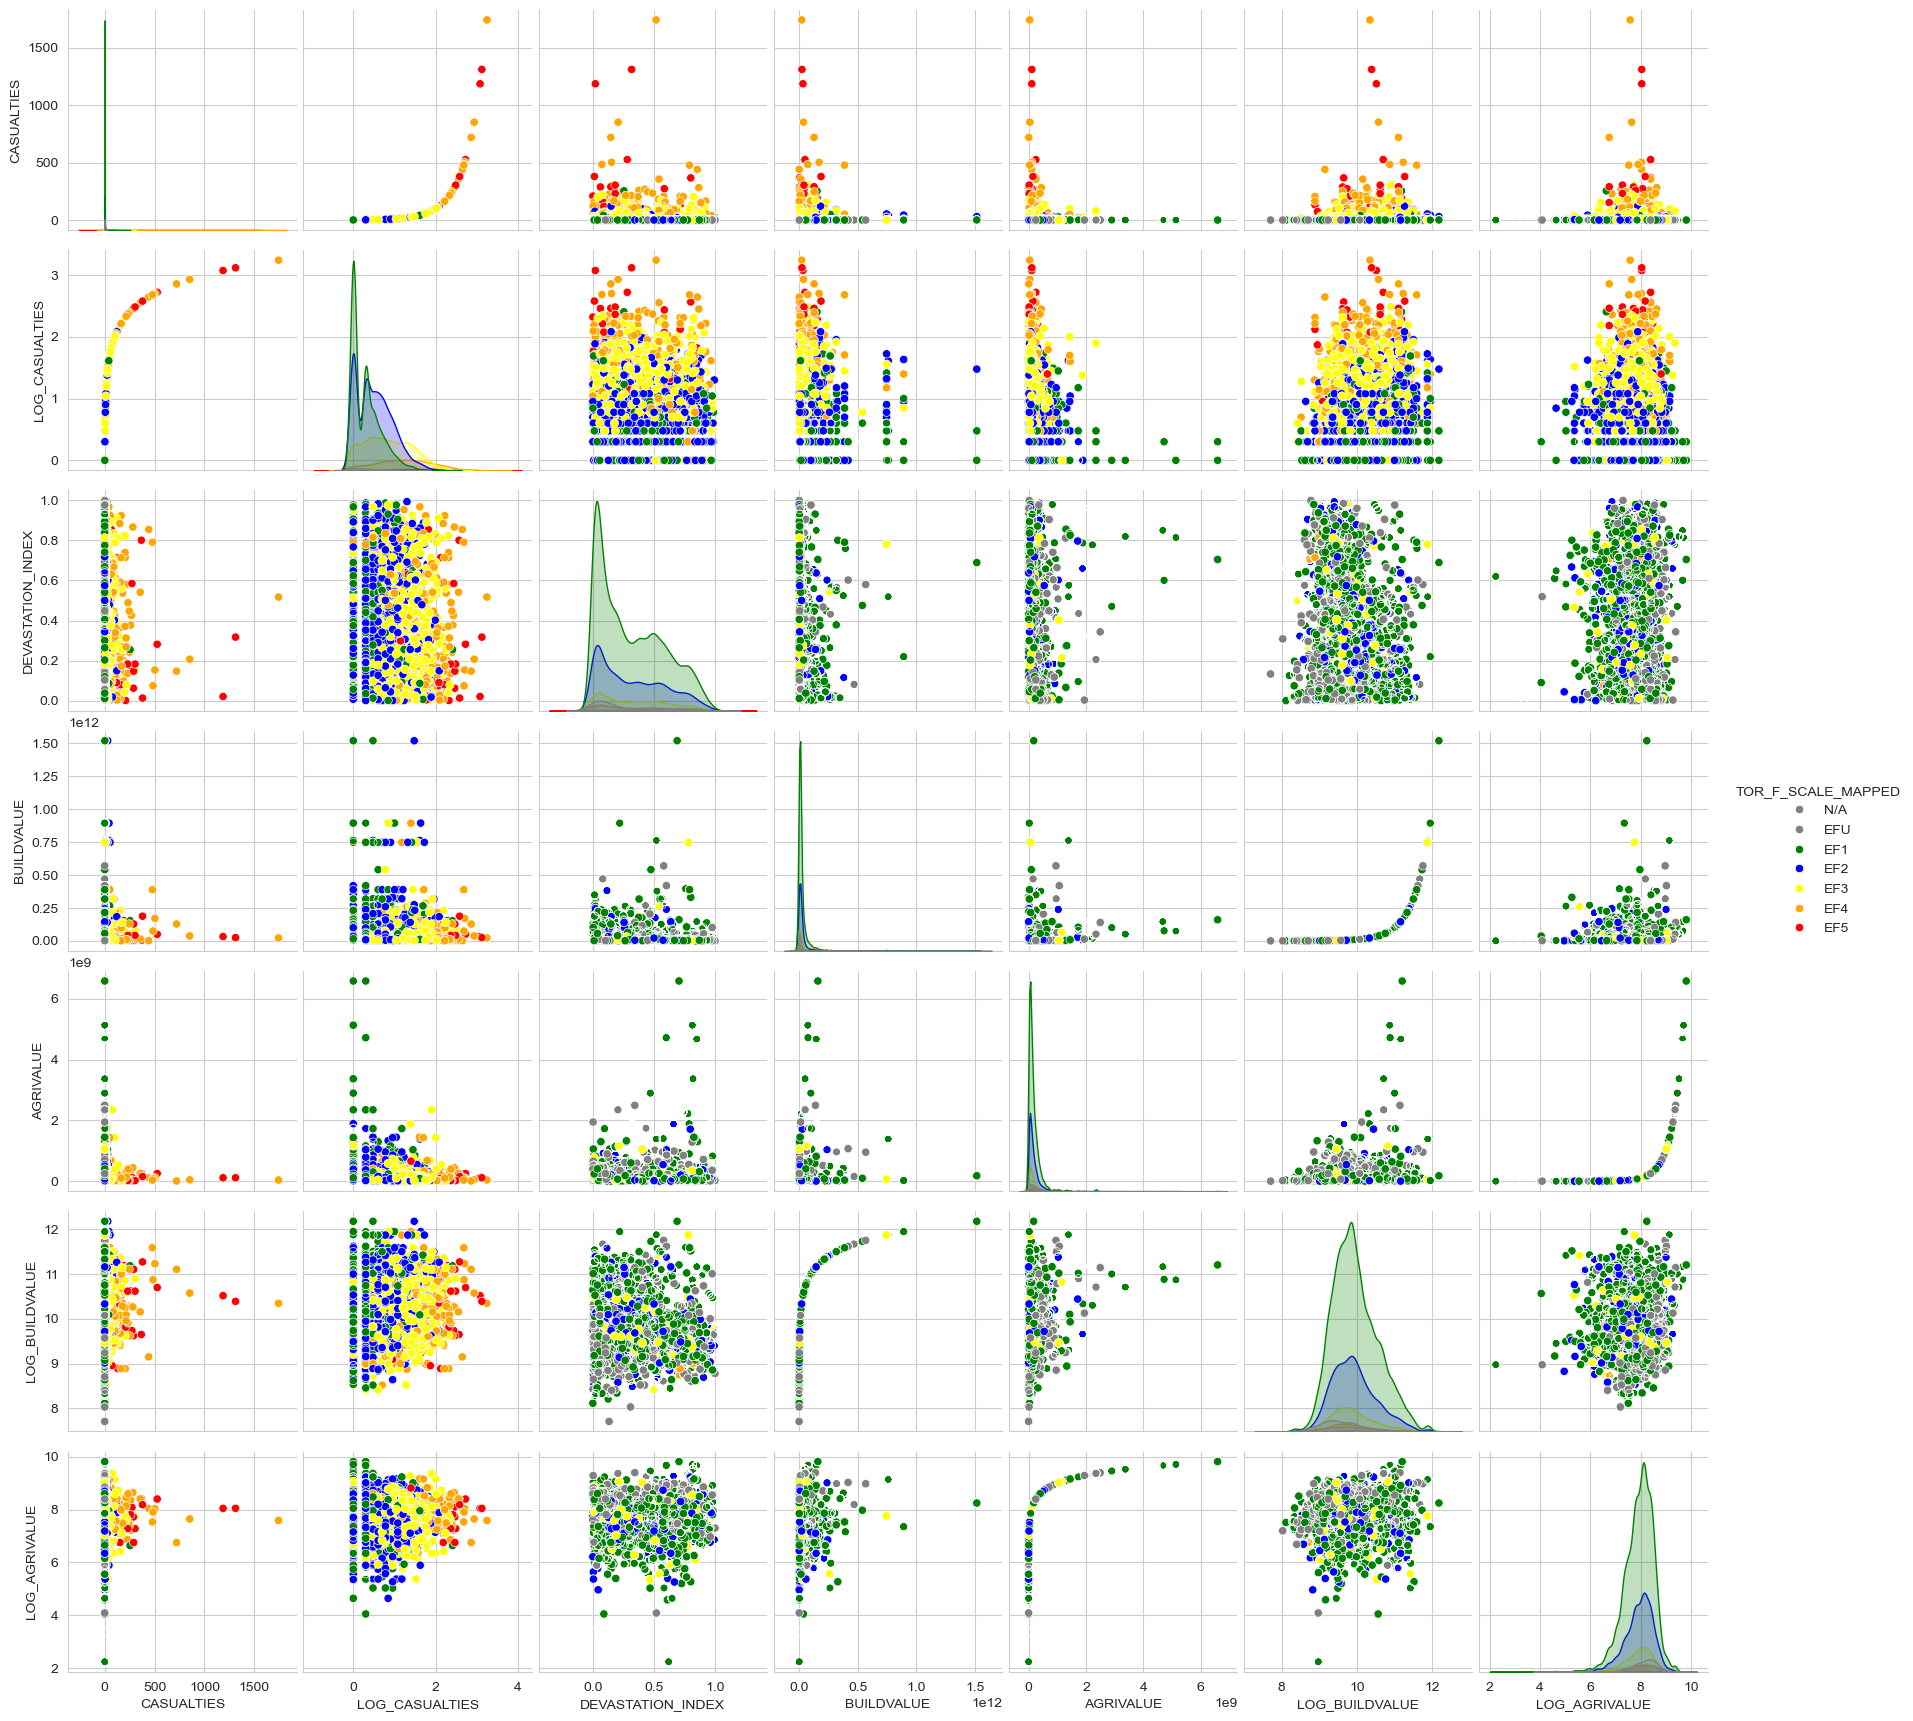

In [72]:
feats = ['CASUALTIES','LOG_CASUALTIES','DEVASTATION_INDEX', 'BUILDVALUE', 'AGRIVALUE','LOG_BUILDVALUE', 'LOG_AGRIVALUE']
cols = feats + ['TOR_F_SCALE_MAPPED']
data = tpd_df[cols]
sns.pairplot(data=data,
    x_vars=feats,
    y_vars=feats,
    hue='TOR_F_SCALE_MAPPED',
    palette={'N/A':'grey','EFU':'grey','EF1':'green','EF2':'blue','EF3':'yellow','EF4':'orange','EF5':'red'},
    hue_order=['N/A','EFU','EF1','EF2','EF3','EF4','EF5']
)
plt.show()

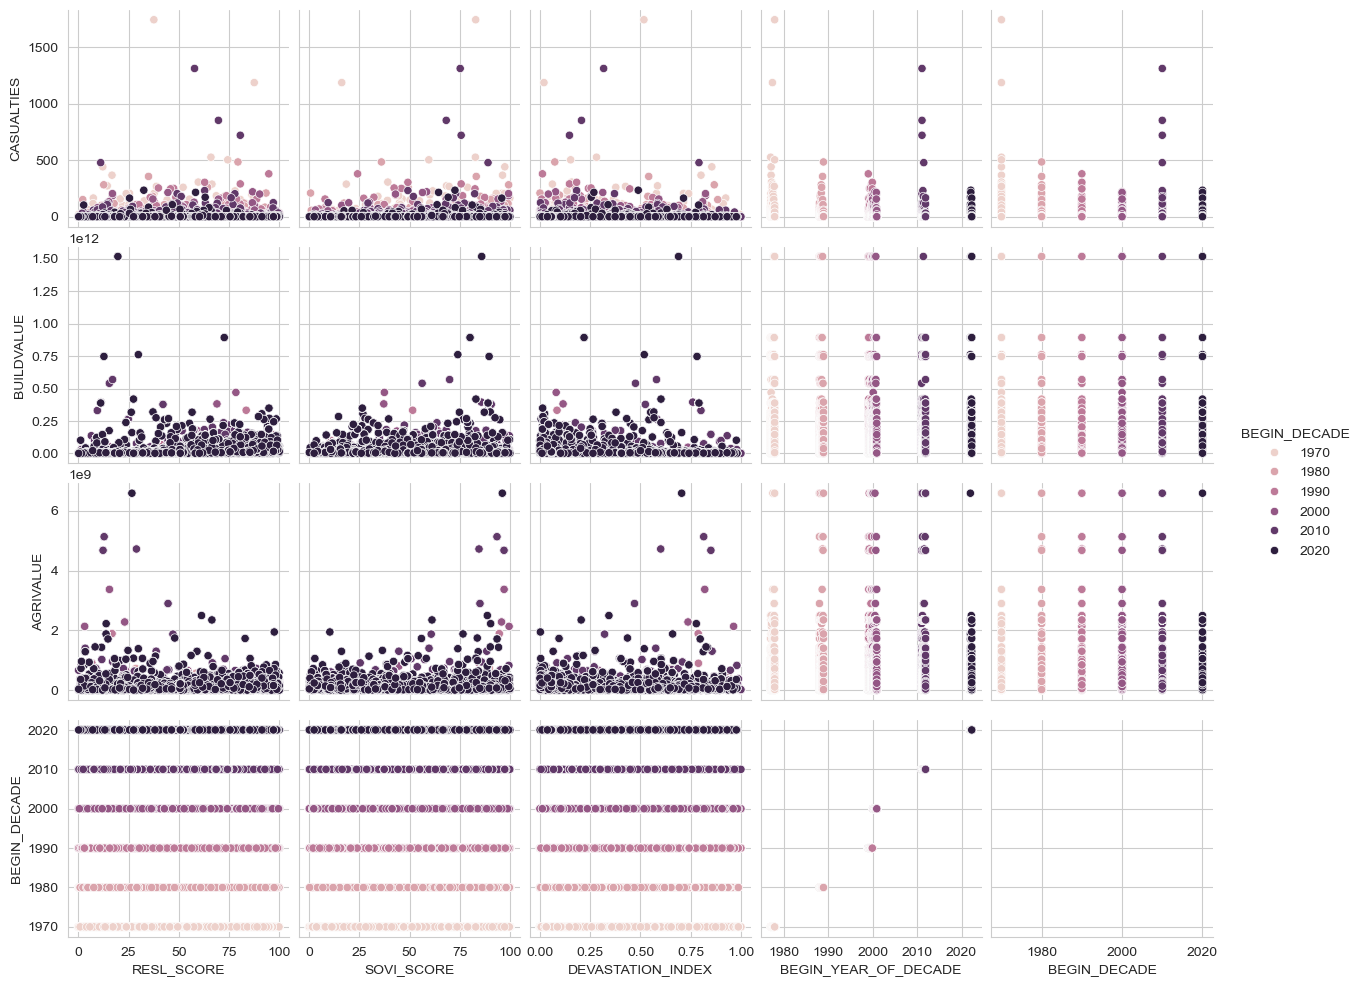

In [110]:
xs = ['RESL_SCORE', 'SOVI_SCORE','DEVASTATION_INDEX','BEGIN_YEAR_OF_DECADE','BEGIN_DECADE']
ys = ['CASUALTIES','BUILDVALUE','AGRIVALUE']
cols = xs + ys + ['TOR_F_SCALE_MAPPED']
data = tpd_df[cols]
sns.pairplot(data=data,
    x_vars=xs,
    y_vars=ys + ['BEGIN_DECADE'],
    hue='BEGIN_DECADE',
    #palette={'N/A':'grey','EFU':'grey','EF1':'green','EF2':'blue','EF3':'yellow','EF4':'orange','EF5':'red'},
    #hue_order=['N/A','EFU','EF1','EF2','EF3','EF4','EF5']
)
plt.show()

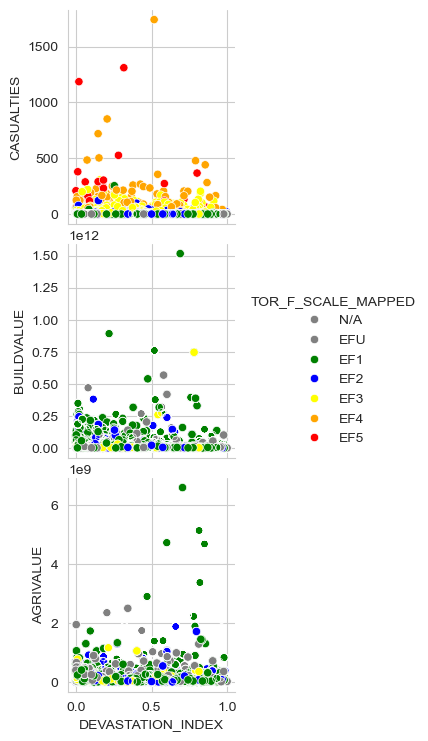

In [74]:
xs = ['DEVASTATION_INDEX']
ys = ['CASUALTIES','BUILDVALUE','AGRIVALUE']
cols = list(set(xs + ys + ['TOR_F_SCALE_MAPPED']))
data = tpd_df[cols]
sns.pairplot(data=data,
    x_vars=xs,
    y_vars=ys,
    hue='TOR_F_SCALE_MAPPED',
    palette={'N/A':'grey','EFU':'grey','EF1':'green','EF2':'blue','EF3':'yellow','EF4':'orange','EF5':'red'},
    hue_order=['N/A','EFU','EF1','EF2','EF3','EF4','EF5']
)
plt.show()

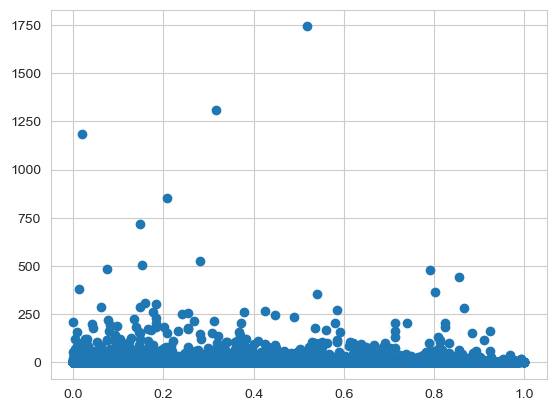

In [75]:
plt.scatter(tpd_df['DEVASTATION_INDEX'],
            tpd_df['CASUALTIES']
)

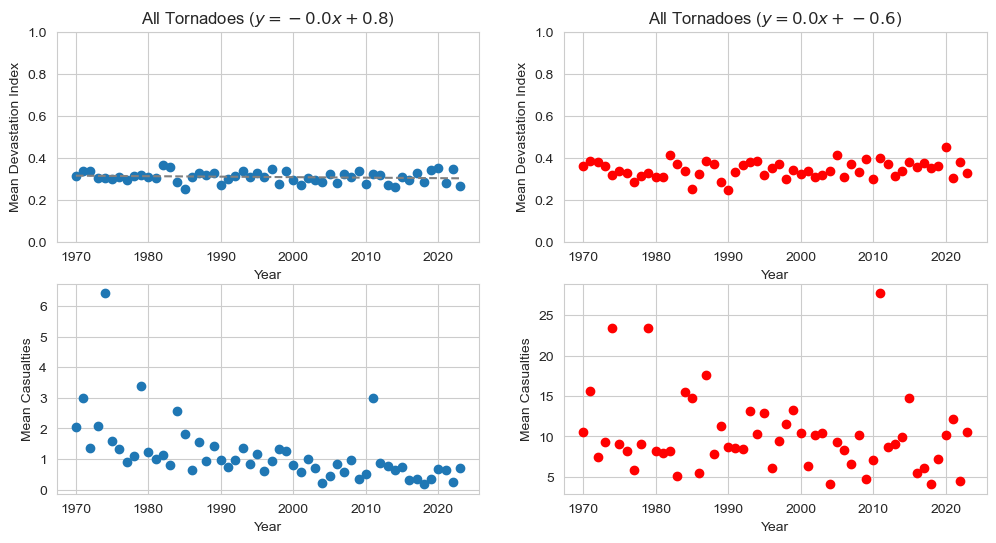

In [102]:
data = tpd_df[['BEGIN_YEAR','DEVASTATION_INDEX','CASUALTIES']].groupby('BEGIN_YEAR').mean().reset_index()
death_data = tpd_df[tpd_df['CASUALTIES'] > 0][['BEGIN_YEAR','DEVASTATION_INDEX','CASUALTIES']].groupby('BEGIN_YEAR').mean().reset_index()

fig, axs = plt.subplots(2,2,figsize=(12,6))

axs[0][0].scatter(data['BEGIN_YEAR'],
            data['DEVASTATION_INDEX'],
            label='Mean Devastation Index'
)
axs[0][0].set_xlabel('Year')
axs[0][0].set_ylabel('Mean Devastation Index')
axs[0][0].set_ylim((0,1))
x = data['BEGIN_YEAR']
y = data['DEVASTATION_INDEX']
z = np.polyfit(x, y, 1)
p = np.poly1d(z) 
eq = f"$y={round(p.c[0],1)}x + {round(p.c[1],1)}$"
axs[0][0].set_title(f'All Tornadoes ({eq})')
axs[0][0].plot(x,p(x),linestyle='--',c='grey')



axs[1][0].scatter(data['BEGIN_YEAR'],
            data['CASUALTIES'],
            label='Mean Devastation Index'
)
axs[1][0].set_xlabel('Year')
axs[1][0].set_ylabel('Mean Casualties')

axs[0][1].scatter(death_data['BEGIN_YEAR'],
            death_data['DEVASTATION_INDEX'],
            label='Mean Devastation Index',
            c='red'
)
axs[0][1].set_xlabel('Year')
axs[0][1].set_ylabel('Mean Devastation Index')
axs[0][1].set_ylim((0,1))
x = death_data['BEGIN_YEAR']
y = death_data['DEVASTATION_INDEX']
z = np.polyfit(x, y, 1)
p = np.poly1d(z) 
eq = f"$y={round(p.c[0],1)}x + {round(p.c[1],1)}$"
axs[0][1].set_title(f'All Tornadoes ({eq})')

axs[1][1].scatter(death_data['BEGIN_YEAR'],
            death_data['CASUALTIES'],
            label='Mean Devastation Index',
            c='red'
)
axs[1][1].set_xlabel('Year')
axs[1][1].set_ylabel('Mean Casualties')

plt.show()

0.035073883857626824

In [77]:
fips_history = tpd_df[['FIPS','CASUALTIES','TOR_F_SCALE_MAPPED','BEGIN_YEAR','EVENT_ID','LOG_CASUALTIES']]
fh_group = fips_history.groupby(['FIPS','TOR_F_SCALE_MAPPED','BEGIN_YEAR']).nunique().reset_index()
multis = fh_group[fh_group['EVENT_ID'] > 5].FIPS.unique()

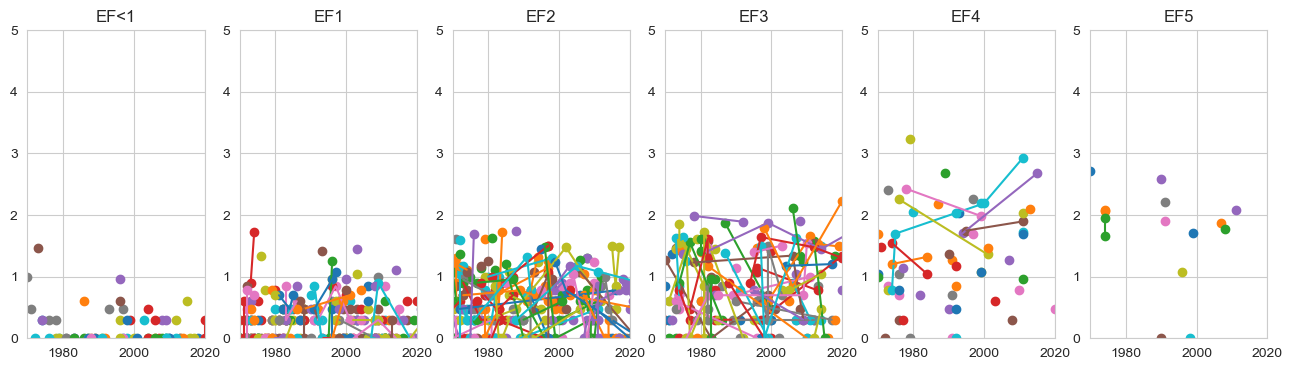

In [78]:
#data = fips_history[(fips_history['FIPS'].isin([choice(multis) for _ in range (1000)]))].sort_values(['BEGIN_YEAR','EVENT_ID'])
data = fips_history[(fips_history['FIPS'].isin(multis))].sort_values(['BEGIN_YEAR','EVENT_ID'])
fig, axs = plt.subplots(1,6,figsize=(16,4))

for idx, ef in enumerate(['EF<1','EF1','EF2','EF3','EF4','EF5']):
    if ef != 'EF<1':
        sub_data = data[data['TOR_F_SCALE_MAPPED'] == ef]
    else:
        sub_data = data[data['TOR_F_SCALE_MAPPED'].isin(['EFU','EF0'])]
    fips = sub_data['FIPS'].unique()
    for fip in fips:
        f_data = sub_data[sub_data['FIPS'] == fip]
        x, y = f_data['BEGIN_YEAR'], f_data['LOG_CASUALTIES']

        axs[idx].scatter(x,y)
        axs[idx].plot(x,y)
        axs[idx].set_title(ef)
        axs[idx].set_xlim((1970,2020))
        axs[idx].set_ylim((0,5))
       
        #z = np.polyfit(x, y, 1)
        #p = np.poly1d(z) 
        #axs[idx].plot(x,p(x),linestyle='--')

* Are tornadoes moving toward more densely populated areas (is there a correlation btwn year and population)
    * Not really
* Do tornadoes bring more casualties to more densely populated areas? (Corr btw casualties and population)
    * Inconclusive; there's basically a normal distribution between LOG_POP and LOG_CASUALTIES, but the much more indicative effect is TOR_F_SCALE
* Are per-tornado fatality rates increasing? (Is mean casualty correlated with year?)
    * No, but this is more likely due to improved building practices, medical tech, emergency response policies, FEMA, many many other confounding factors
* Train a model that says "What are the expected casualties of an EF $X$, in a county with a density of $Y$, with an orientation of $Z$ to the historical mean, $A$ miles from the mean"
* Is Tornado Season moving? 
    * Maybe! It would be interesting to see how the 50th, 75th, 90th percentiles have shifted

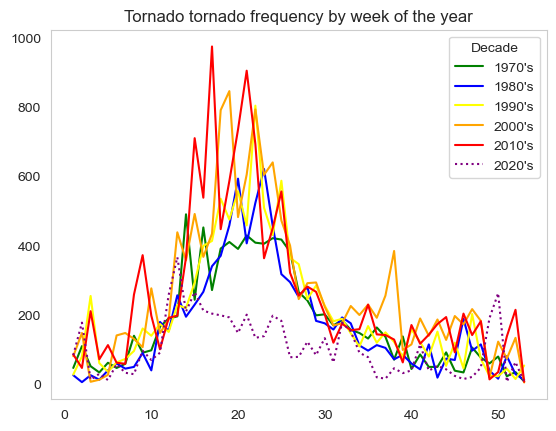

In [81]:
x_col = 'BEGIN_DECADE'
foo = tdf_cpop[['BEGIN_DAY_OF_YEAR','BEGIN_MONTH','BEGIN_WEEK_OF_YEAR','EVENT_ID','TOR_F_SCALE_MAPPED',x_col]].groupby(['BEGIN_WEEK_OF_YEAR',x_col]).count().reset_index()

colors = {
    1970:'green',
    1980:'blue',
    1990:'yellow',
    2000:'orange',
    2010:'red',
    2020:'purple',
}

linestyle = {decade: 'dotted' if decade == 2020 else 'solid' for decade in colors.keys()}

for decade in foo[x_col].unique():
    bar = foo[foo[x_col] == decade]
    plt.plot(
        bar['BEGIN_WEEK_OF_YEAR'],
        bar['EVENT_ID'],
        label=str(decade)+"'s",
        c=colors[decade],
        linestyle=linestyle[decade]
    )

plt.legend(title='Decade')
plt.title('Tornado tornado frequency by week of the year')
plt.grid(False)
plt.show()

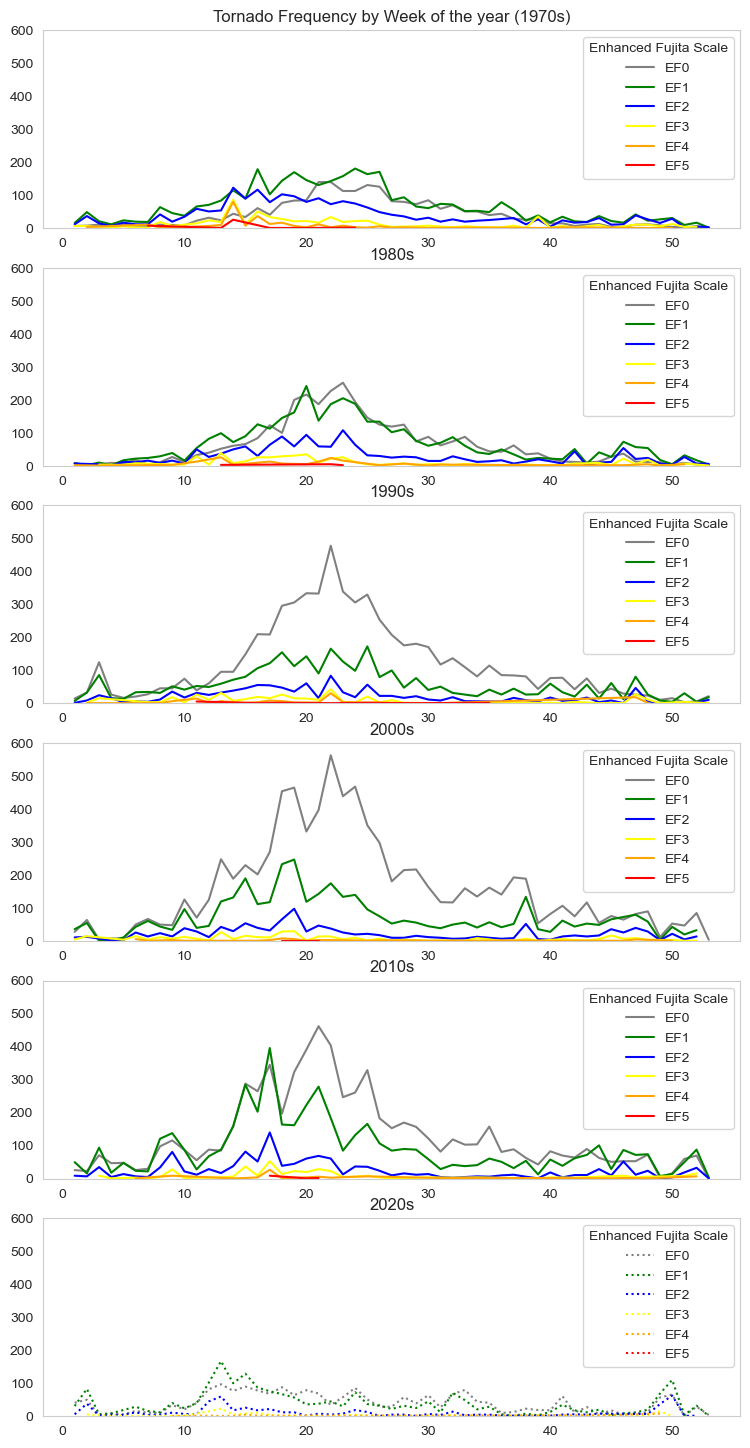

In [82]:
x_col = 'BEGIN_DECADE'
tdf_cpop_prep = tdf_cpop[~tdf_cpop['TOR_F_SCALE_MAPPED'].isin(['EFU','N/A'])]
foo = tdf_cpop_prep[['BEGIN_DAY_OF_YEAR','BEGIN_MONTH','BEGIN_WEEK_OF_YEAR','EVENT_ID','TOR_F_SCALE_MAPPED',x_col]].groupby(['BEGIN_WEEK_OF_YEAR',x_col,'TOR_F_SCALE_MAPPED']).count().reset_index()

colors = {'N/A':'grey','EFU':'grey','EF0':'grey','EF1':'green','EF2':'blue','EF3':'yellow','EF4':'orange','EF5':'red'}

tor_f = foo.TOR_F_SCALE_MAPPED.unique()
dec = foo.BEGIN_DECADE.unique()

linestyle = {decade: 'dotted' if decade == 2020 else 'solid' for decade in dec}

fig, axs = plt.subplots(len(dec),1,figsize=(9,18))

for d_i, decade in enumerate(dec):
    for e_i, ef in enumerate(tor_f):
        bar = foo[(foo['BEGIN_DECADE'] == decade) & (foo['TOR_F_SCALE_MAPPED'] == ef)]
        axs[d_i].plot(
            bar['BEGIN_WEEK_OF_YEAR'],
            bar['EVENT_ID'],
            c=colors[ef],
            label=ef,
            linestyle=linestyle[decade]
        )
        axs[d_i].legend(title='Enhanced Fujita Scale')
        axs[d_i].set_title(str(decade) + 's')
        axs[d_i].grid(False)
        axs[d_i].set_ylim((0,600))

axs[0].set_title('Tornado Frequency by Week of the year (1970s)')
plt.show()

Text(0.5, 1.0, 'Mean casualties over time\n$f(x) = -0.05x + 115.6$')

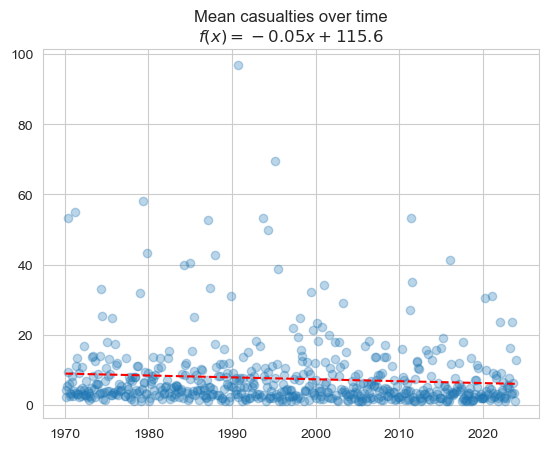

In [127]:
#foo = tdf_cpop[tdf_cpop['BEGIN_YEAR'] < 2024][['BEGIN_MONTH_YEAR','CASUALTIES']].groupby('BEGIN_MONTH_YEAR').mean().reset_index()
foo = tdf_cpop[tdf_cpop['CASUALTIES'] > 0][['BEGIN_MONTH_YEAR','CASUALTIES']].groupby('BEGIN_MONTH_YEAR').mean().reset_index()


plt.scatter(
    foo['BEGIN_MONTH_YEAR'],
    foo['CASUALTIES'],
    alpha=0.3
)
z = np.polyfit(foo['BEGIN_MONTH_YEAR'], foo['CASUALTIES'], 1)
p = np.poly1d(z)
plt.plot(foo['BEGIN_MONTH_YEAR'],p(foo['BEGIN_MONTH_YEAR']),"r--")
m, b = round(p.c[0],2), round(p.c[1],1)
plt.title(f"Mean casualties over time\n$f(x) = {m}x + {b}$")


In [124]:
tpd_df[tpd_df['CASUALTIES'] == tpd_df.CASUALTIES.max()]

,STORM_ID,EPISODE_ID,EVENT_ID,BEGIN_DAY,BEGIN_YEAR,BEGIN_DECADE,BEGIN_YEAR_OF_DECADE,BEGIN_MONTH,BEGIN_QUARTER,BEGIN_YEAR_QUARTER,BEGIN_DATE,BEGIN_DAY_OF_YEAR,BEGIN_WEEK_OF_YEAR,BEGIN_WEEK_YEAR,BEGIN_MONTH_YEAR,ORIENTATION_FROM_MEAN,COUNTY,COUNTY,STATE,STATE,FIPS,POPULATION,LOG_POPULATION,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,TOR_LENGTH,LOG_TOR_LENGTH,TOR_WIDTH,LOG_TOR_WIDTH,BEGIN_LAT,BEGIN_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,TOR_F_SCALE_MAPPED,CASUALTIES,LOG_CASUALTIES,CLUSTER_EPISODE_ID,BUILDVALUE,LOG_BUILDVALUE,LOG_AGRIVALUE,AGRIVALUE,RESL_SCORE,SOVI_SCORE,DEVASTATION_INDEX,FATALITY_EF0,INJURY_EF0,DAMAGE_EF0,FATALITY_EF1,INJURY_EF1,DAMAGE_EF1,FATALITY_EF2,INJURY_EF2,DAMAGE_EF2,FATALITY_EF3,INJURY_EF3,DAMAGE_EF3,FATALITY_EF4,INJURY_EF4,DAMAGE_EF4,FATALITY_EF5,INJURY_EF5,DAMAGE_EF5
9328,4188,<NA>,10130768,10,1979,1970,1977.9,4,1,19791,1979-04-10,100,15,1979.288462,1979.333333,1,Wichita,Wichita,TEXAS,Texas,48485,121300.0,5.083861,1700,0,42,0,12.9,1.11059,1760.0,3.245513,33.83,-98.63,NaN,NaN,EF4,1742,3.241048,NaN,2.223347e+10,10.347007,7.587889,38715901.0,37.560001,82.849998,0.517315,120.298484,5219.617558,371505.472648,33.416246,942.338125,4.429311e+06,46.782744,969.071122,3.407384e+07,100.248737,1383.432567,2.496908e+08,140.348231,2051.757478,8.616063e+08,414.361445,2786.914881,6.833804e+09


# CONVEX HULL CALCULATIONS
Uses Jarvis march to build a convex hull containing all points $s$ in a set of points $S$.

In [84]:
class Point:
    def __init__(self, id, x, y):
        self.id = id
        self.x = x
        self.y = y
    
def leftmost_point(points):
    return min(points, key = lambda p: p.x)

def is_ccw(p0,p1,p2):
    # returns true if p1 is ccw to p0 relative to p2
    A = np.array([p0.x,p0.y])
    B = np.array([p1.x,p1.y])
    C = np.array([p2.x,p2.y])
    return np.cross(B - A, C - A) < 0

def convex_hull(point_list):
    first_point = leftmost_point(point_list)
    hull_ids = [point_list.index(first_point)]
    start = leftmost_point(point_list)

    target = choice(point_list)
    while target == start:
        target = choice(point_list)
    working_pl = point_list.copy()

    while first_point.id != target.id:
        target = working_pl[0]
        for p in working_pl:
            if (is_ccw(start,p,target)):
                target = p
        hull_ids.append(point_list.index(target))
        start = target
        del(working_pl[working_pl.index(target)])
    return hull_ids


In [85]:

decades = tdf.BEGIN_DECADE.unique()
decade_hulls = {}

for dec in decades: 
    decade_data = tdf[(tdf['BEGIN_DECADE'] == dec)]
    point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]
    hull_ids = convex_hull(point_list)
    decade_hulls[dec] = hull_ids

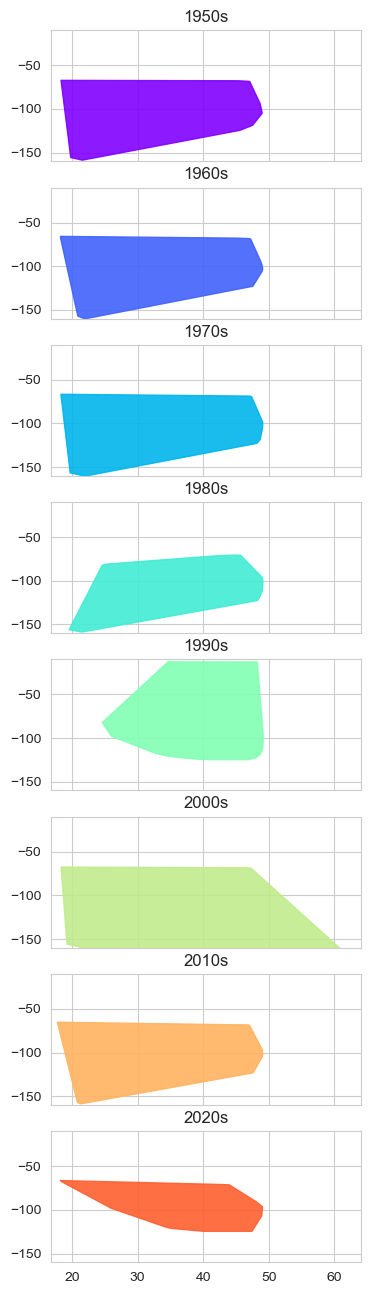

In [86]:
cmap = plt.get_cmap('rainbow')
color_decade_hulls = {}
length = len(decade_hulls) 
for idx, decade in enumerate(decade_hulls.keys()):
    color = list(cmap(idx / length)) # the same as normalizing #
    color[3] = .9    # adds a 20% opacity to the colors
    color_decade_hulls[decade] = {
        'color': color,
        'hull_ids': decade_hulls[decade]
    }
fig, ax = plt.subplots(length,1, sharex=True, sharey=True, figsize=(4,16))

patches = []
idx = 0
for decade, data in color_decade_hulls.items():
    hull_ids = data['hull_ids']
    
    decade_data = tdf[(tdf['BEGIN_DECADE'] == decade)]
    point_list = [Point(*p) for p in zip(decade_data.index, decade_data.BEGIN_LAT, decade_data.BEGIN_LON)]

    polygon = Polygon([[point_list[i].x,point_list[i].y] for i in hull_ids], closed=True, color = data['color'])
    p = PatchCollection([polygon], match_original=True)
    ax[idx].add_collection(p)
    ax[idx].set_title(str(decade) + 's')
    idx +=1

ax = plt.gca()
ax.set_xlim([tdf['BEGIN_LAT'].min() * .95, tdf['BEGIN_LAT'].max() * 1.05])
ax.set_ylim([-160, -10])

plt.show()